In [50]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [51]:
!pip install pyspark

In [52]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import Tokenizer, HashingTF, StringIndexer
from pyspark.ml.classification import NaiveBayes
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.functions import col, udf, split, explode, size, array_remove, array_contains, regexp_replace, lower, collect_list
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [53]:
# Create a Spark session
spark = SparkSession.builder.appName("MentalHealthPrediction").getOrCreate()

In [54]:
# Load the data
data = spark.read.csv("/content/drive/MyDrive/College/Sem5/BigDataLanj/Kelompok/mental_health.csv", header=True, inferSchema=True)

In [55]:
data.show(10)

+--------------------+-----+
|                text|label|
+--------------------+-----+
|dear american tee...|    0|
|nothing look forw...|    1|
|music recommendat...|    0|
|im done trying fe...|    1|
|worried  year old...|    1|
|hey rredflag sure...|    1|
|feel like someone...|    0|
|deserve liveif di...|    1|
|feels good ive se...|    1|
|live guiltok made...|    1|
+--------------------+-----+
only showing top 10 rows



In [56]:
data.describe().show()

data.printSchema()

+-------+--------------------+-------------------+
|summary|                text|              label|
+-------+--------------------+-------------------+
|  count|               27977|              27977|
|   mean|                NULL|0.49462058119169316|
| stddev|                NULL| 0.4999799966498138|
|    min|                    |                  0|
|    max|zoomposting real ...|                  1|
+-------+--------------------+-------------------+

root
 |-- text: string (nullable = true)
 |-- label: integer (nullable = true)



In [57]:
duplicate_count = data.count() - data.dropDuplicates().count()
print("Duplicate count:", duplicate_count)

Duplicate count: 5


In [58]:
data = data.dropDuplicates()

In [59]:
from pyspark.sql.functions import length, avg

data = data.withColumn("length", length("text"))

In [60]:
data_big = data.filter(col('length') >= 4096)
data_big.count()

136

In [61]:
data = data.subtract(data_big)

In [62]:
data.describe().show()

+-------+--------------------+------------------+-----------------+
|summary|                text|             label|           length|
+-------+--------------------+------------------+-----------------+
|  count|               27836|             27836|            27836|
|   mean|                NULL|  0.49285098433683|436.9363414283661|
| stddev|                NULL|0.4999578694620589|542.3475517942366|
|    min|                    |                 0|                2|
|    max|zoomposting real ...|                 1|             4087|
+-------+--------------------+------------------+-----------------+



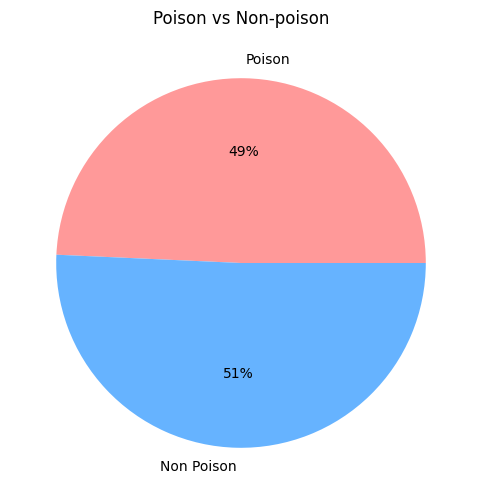

In [63]:
sarcastic_counts = data.groupBy("label").count().collect()

non_sarcastic_count = sarcastic_counts[0]["count"]
sarcastic_count = sarcastic_counts[1]["count"]

labels = ['Poison', 'Non Poison']
sizes = [non_sarcastic_count, sarcastic_count]
colors = ['#ff9999', '#66b3ff']

plt.figure(figsize=(8, 6))
plt.pie(sizes, labels=labels, autopct='%1.0f%%', colors=colors)
plt.title('Poison vs Non-poison')

plt.show()

In [64]:
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, StringType
import re

def extract_text(text):
    # Add more patterns as needed
    patterns = {
      r"\bim\b": "i am",
      r"\byoure\b": "you are",
      r"\bhes\b": "he is",
      r"\bshes\b": "she is",
      r"\bwere\b": "we are",
      r"\btheyre\b": "they are",
      r"\bive\b": "i have",
      r"\byouve\b": "you have",
      r"\bweve\b": "we have",
      r"\btheyve\b": "they have",
      r"\bwasnt\b": "was not",
      r"\bwont\b": "will not",
      r"\bcant\b": "cannot",
      r"\bdont\b": "do not",
      r"\bdoesnt\b": "does not",
      r"\bdidnt\b": "did not",
      r"\bhavent\b": "have not",
      r"\bhasnt\b": "has not",
      r"\bhadnt\b": "had not",
      r"\barent\b": "are not",
      r"\bwerent\b": "were not",
      r"\bisnt\b": "is not",
      r"\byoull\b": "you will",
      r"\bwell\b": "we will",
      r"\btheyll\b": "they will",
      r"\bill\b": "i will",
      r"\bhell\b": "he will",
      r"\bshell\b": "she will",
      r"\bitll\b": "it will",
      r"\bshed\b": "she would",
      r"\bhed\b": "he would",
      r"\bid\b": "i would",
      r"\byoud\b": "you would",
      r"\bwed\b": "we would",
      r"\btheyd\b": "they would",
      r"\bcouldve\b": "could have",
      r"\bshouldve\b": "should have",
      r"\bwouldve\b": "would have",
      r"\bwhos\b": "who is",
      r"\bwhats\b": "what is",
      r"\bwheres\b": "where is",
      r"\bwhens\b": "when is",
      r"\bwhys\b": "why is",
      r"\bhows\b": "how is",
      r"\bwhod\b": "who would",
      r"\bwhatd\b": "what would",
      r"\bwhered\b": "where would",
      r"\bwhend\b": "when would",
      r"\bwhyd\b": "why would",
      r"\bhowd\b": "how would",
      r"\bwholl\b": "who will",
      r"\bwhatll\b": "what will",
      r"\bwherell\b": "where will",
      r"\bwhenll\b": "when will",
      r"\bwhyll\b": "why will",
      r"\bhowll\b": "how will",
      r"\bwhore\b": "who are",
      r"\bwhatre\b": "what are",
      r"\bwherere\b": "where are",
      r"\bwhenre\b": "when are",
      r"\bwhyre\b": "why are",
      r"\bhowre\b": "how are",
      r"\bthats\b": "that is",
      r"\bthiss\b": "this is",
      r"\btheres\b": "there is",
      r"\bheres\b": "here is",
      r"\bits\b": "it is",
      r"\bwhove\b": "who have",
      r"\bwhatve\b": "what have",
      r"\bwhereve\b": "where have",
      r"\bwhenve\b": "when have",
      r"\bwhyve\b": "why have",
      r"\bhowve\b": "how have",
      r"\bimma\b": "i am going to",
      r"\bgonna\b": "going to",
      r"\bgotta\b": "got to",
      r"\bwanna\b": "want to",
      r"\bhafta\b": "have to",
      r"\bkinda\b": "kind of",
      r"\bsorta\b": "sort of",
      r"\blemme\b": "let me",
      r"\boutta\b": "out of",
      r"\bgotcha\b": "got you",
      # add more contractions and their expanded forms
    }

    # Function to apply substitution to each token in the array
    def process_token(token):
       for pattern, replacement in patterns.items():
           token = re.sub(pattern, replacement, token)
       return token

    processed_text = process_token(text)

    return processed_text


# Register the function as a UDF (User Defined Function)
extract_text_udf = udf(extract_text, StringType())

# Apply the UDF to the 'filtered_words' column (or the column you want to extract text from)
data = data.withColumn('extracted_text', extract_text_udf('text'))


In [65]:
from pyspark.ml.feature import StopWordsRemover, Tokenizer

tokenizer = Tokenizer(inputCol="extracted_text", outputCol="tokened")
data = tokenizer.transform(data)

In [66]:
import nltk
nltk.download('stopwords')
stopwords_remover = StopWordsRemover(inputCol="tokened", outputCol="filtered")

# Fit and transform the DataFrame
data = stopwords_remover.transform(data)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [67]:
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from pyspark.sql.functions import udf, transform

nltk.download('wordnet')

def penn2morphy(penntag):
   """ Converts Penn Treebank tags to WordNet. """
   morphy_tag = {'NN':'n', 'JJ':'a', 'VB':'v', 'RB':'r'}
   try:
       return morphy_tag[penntag[:2]]
   except:
       return 'n'

def lemmatize(words):
   lemmatizer = WordNetLemmatizer()
   return [lemmatizer.lemmatize(word.lower(), pos=penn2morphy(tag))
           for word, tag in pos_tag(words)]

lemmatize_udf = udf(lemmatize, ArrayType(StringType()))

data = data.withColumn('lemmatized', lemmatize_udf(data['filtered']))

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [68]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [69]:
data.printSchema()

root
 |-- text: string (nullable = true)
 |-- label: integer (nullable = true)
 |-- length: integer (nullable = true)
 |-- extracted_text: string (nullable = true)
 |-- tokened: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- filtered: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- lemmatized: array (nullable = true)
 |    |-- element: string (containsNull = true)



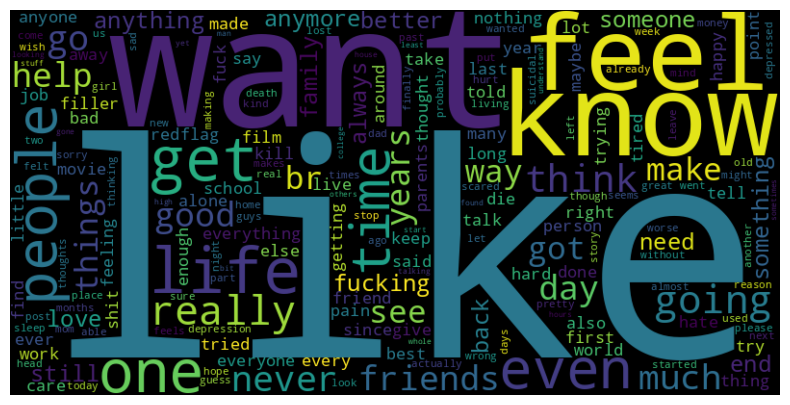

In [70]:
data_words = data.select(explode("filtered").alias("word"))

wordcloud_data = data_words.groupBy("word").count().toPandas()

wordcloud = WordCloud(width=800, height=400, background_color="black").generate_from_frequencies(wordcloud_data.set_index("word")["count"].to_dict())

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [71]:
def remove_empty_strings(array):
   return [x for x in array if x != '']

remove_empty_strings_udf = udf(remove_empty_strings, ArrayType(StringType()))

data = data.withColumn("lemmatized", remove_empty_strings_udf(data["lemmatized"]))

In [72]:
data.show(5)

+--------------------+-----+------+--------------------+--------------------+--------------------+--------------------+
|                text|label|length|      extracted_text|             tokened|            filtered|          lemmatized|
+--------------------+-----+------+--------------------+--------------------+--------------------+--------------------+
|crazy believing b...|    1|   381|crazy believing b...|[crazy, believing...|[crazy, believing...|[crazy, believe, ...|
|trusting peoplehe...|    1|  1085|trusting peoplehe...|[trusting, people...|[trusting, people...|[trust, peoplehey...|
|im gonna say care...|    0|    75|i am going to say...|[i, am, going, to...|[going, say, care...|[go, say, care, k...|
|dont need sleep n...|    0|   129|do not need sleep...|[do, not, need, s...|[need, sleep, nee...|[need, sleep, nee...|
|feel like im goin...|    1|   209|feel like i am go...|[feel, like, i, a...|[feel, like, goin...|[feel, like, go, ...|
+--------------------+-----+------+-----

In [73]:
from pyspark.ml.feature import HashingTF, IDF, Tokenizer

hashingTF = HashingTF(inputCol="lemmatized", outputCol="rawFeatures", numFeatures=1000)
data = hashingTF.transform(data)

idf = IDF(inputCol="rawFeatures", outputCol="features")
idfModel = idf.fit(data)
data = idfModel.transform(data)

In [74]:
data.show(5)

+--------------------+-----+------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|                text|label|length|      extracted_text|             tokened|            filtered|          lemmatized|         rawFeatures|            features|
+--------------------+-----+------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|crazy believing b...|    1|   381|crazy believing b...|[crazy, believing...|[crazy, believing...|[crazy, believe, ...|(1000,[69,87,104,...|(1000,[69,87,104,...|
|trusting peoplehe...|    1|  1085|trusting peoplehe...|[trusting, people...|[trusting, people...|[trust, peoplehey...|(1000,[12,14,34,9...|(1000,[12,14,34,9...|
|im gonna say care...|    0|    75|i am going to say...|[i, am, going, to...|[going, say, care...|[go, say, care, k...|(1000,[69,211,310...|(1000,[69,211,310...|
|dont need sleep n...|    0|

In [75]:
data = data.drop('tokened')
data = data.drop('filtered')
data = data.drop('lemmatized')
data = data.drop('extracted_text')

In [76]:
data.show(5)

+--------------------+-----+------+--------------------+--------------------+
|                text|label|length|         rawFeatures|            features|
+--------------------+-----+------+--------------------+--------------------+
|crazy believing b...|    1|   381|(1000,[69,87,104,...|(1000,[69,87,104,...|
|trusting peoplehe...|    1|  1085|(1000,[12,14,34,9...|(1000,[12,14,34,9...|
|im gonna say care...|    0|    75|(1000,[69,211,310...|(1000,[69,211,310...|
|dont need sleep n...|    0|   129|(1000,[169,256,33...|(1000,[169,256,33...|
|feel like im goin...|    1|   209|(1000,[17,57,90,1...|(1000,[17,57,90,1...|
+--------------------+-----+------+--------------------+--------------------+
only showing top 5 rows



In [77]:
(training_data, testing_data) = data.randomSplit([0.8, 0.2], seed=2023)

In [78]:
nb = NaiveBayes(smoothing=1.0, modelType="multinomial", labelCol="label", featuresCol="features")
model = nb.fit(training_data)

In [79]:
predictions = model.transform(testing_data)

In [80]:
predictions.show(5)

+--------------------+-----+------+--------------------+--------------------+--------------------+--------------------+----------+
|                text|label|length|         rawFeatures|            features|       rawPrediction|         probability|prediction|
+--------------------+-----+------+--------------------+--------------------+--------------------+--------------------+----------+
| amp im scared al...|    1|  1534|(1000,[1,3,7,11,3...|(1000,[1,3,7,11,3...|[-3125.1743453818...|[1.41042897180514...|       1.0|
| chance death red...|    1|   165|(1000,[31,75,83,1...|(1000,[31,75,83,1...|[-359.11249317679...|[0.57930721540775...|       0.0|
| decided im much ...|    1|   246|(1000,[32,103,115...|(1000,[32,103,115...|[-527.38902962121...|[0.10021037965603...|       1.0|
| first timewhen t...|    1|   666|(1000,[19,34,55,6...|(1000,[19,34,55,6...|[-1422.0856755523...|[2.33228289601752...|       1.0|
| followers really...|    0|    32|(1000,[112,188,77...|(1000,[112,188,77...|[-61.6

In [82]:
multi_evaluator = MulticlassClassificationEvaluator(labelCol = 'label')
precision = multi_evaluator.evaluate(predictions, {multi_evaluator.metricName: "weightedPrecision"})
recall = multi_evaluator.evaluate(predictions, {multi_evaluator.metricName: "weightedRecall"})
f1_score = multi_evaluator.evaluate(predictions, {multi_evaluator.metricName: "f1"})
accuracy = multi_evaluator.evaluate(predictions, {multi_evaluator.metricName: "accuracy"})

print("Classification Report:")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")
print(f"Accuracy: {accuracy:.4f}")

Classification Report:
Precision: 0.8334
Recall: 0.8140
F1 Score: 0.8109
Accuracy: 0.8140


In [83]:
labels = labels = predictions.select("label").rdd.map(lambda x: x[0]).collect()
predicted_labels = labels = predictions.select("prediction").rdd.map(lambda x: x[0]).collect()

unique_labels = sorted(set(labels + predicted_labels))

conf_matrix = [[0] * len(unique_labels) for _ in range(len(unique_labels))]

for true_label, pred_label in zip(labels, predicted_labels):
    conf_matrix[int(true_label)][int(pred_label)] += 1

print("Confusion Matrix:")
for row in conf_matrix:
    print(row)

Confusion Matrix:
[2070, 0]
[0, 3489]


##Prediksi teks

In [ ]:
# create predict one
def predict_one(text):
    df_one = spark.createDataFrame([(text,)], ['text'])
    # remove symbols with regex
    df_one = df_one.withColumn('text', regexp_replace(col('text'), '[^\sa-zA-Z0-9]', ''))
    # lowercase
    df_one = df_one.withColumn('text', lower(col('text')))
    # extract text
    df_one = df_one.withColumn('extracted_text', extract_text_udf('text'))
    df_one = tokenizer.transform(df_one)
    df_one = stopwords_remover.transform(df_one)
    df_one = df_one.withColumn('lemmatized', lemmatize_udf(df_one['filtered']))
    df_one = hashingTF.transform(df_one)
    df_one = idfModel.transform(df_one)
    return model.transform(df_one).collect()[0]['prediction']

In [ ]:
user_input = input("Enter a sentence: ")
prediction = predict_one(user_input)
if prediction == 1:
    print("The input suggests positive mental health.")
else:
    print("The input suggests negative mental health")

Enter a sentence: I want to kill myself
The input suggests positive mental health.


In [ ]:
user_input = input("Enter a sentence: ")
prediction = predict_one(user_input)
if prediction == 1:
    print("The input suggests positive mental health.")
else:
    print("The input suggests negative mental health")

Enter a sentence: There was a black at in my kitchen last night
The input suggests negative mental health
